## Installs the required dependencies

In [1]:
%pip install osmnx
%pip install geopandas
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Disables future warnings

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")


# Step 1: Maps the problem

## Simulates the map

C:\Users\harsh\AppData\Local\Temp\ipykernel_2880\272517100.py:10: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  graph = ox.graph_from_bbox(north, south, east, west, network_type='drive')
C:\Users\harsh\AppData\Local\Temp\ipykernel_2880\272517100.py:10: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  graph = ox.graph_from_bbox(north, south, east, west, network_type='drive')


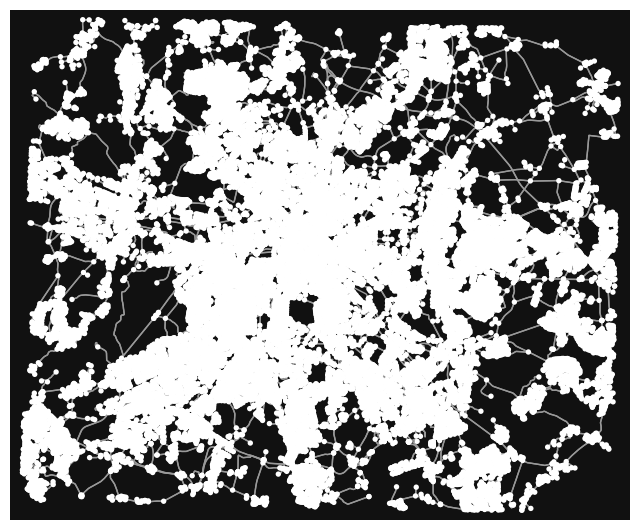

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
import osmnx as ox

# Define the coordinates for the bounding box
north, south, east, west = 52.6755, 52.3382, 13.7611, 13.0884

# Create a bounding box
bbox = ox.utils_geo.bbox_from_point((52.5200, 13.4050), dist=10000) # distance is in meter

# Retrieve the network within this bounding box
graph = ox.graph_from_bbox(north, south, east, west, network_type='drive')


graph_projected = ox.project_graph(graph)
ox.plot_graph(graph_projected)




## Visualizes the map

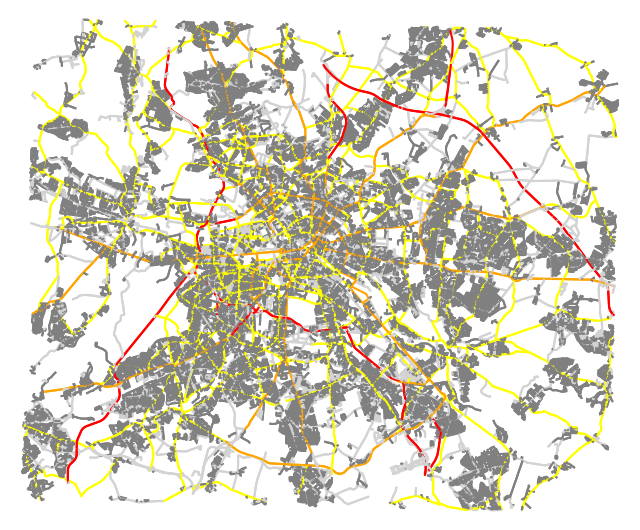

In [4]:
# Customize colors based on road types
color_dict = {
    'motorway': 'red',
    'primary': 'orange',
    'secondary': 'yellow',
    'residential': 'gray',
    'unclassified': 'lightgray', 
}
edge_colors = []
for _, _, data in graph_projected.edges(data=True):

    highway_type = data.get('highway', 'unclassified')
    if isinstance(highway_type, list):
        highway_type = highway_type[0] 

    edge_color = color_dict.get(highway_type, 'lightgray')
    edge_colors.append(edge_color)

fig, ax = ox.plot_graph(graph_projected, edge_color=edge_colors, edge_linewidth=1.5, node_size=0, bgcolor="white")


## Defines the grid size & geographical bounds

In [5]:
import numpy as np
num_x_cells = 100
num_y_cells = 100

grid = np.full((num_y_cells, num_x_cells), np.inf)

## Converts the network graph into a grid

In [6]:
import numpy as np
import osmnx as ox
from shapely.geometry import LineString, MultiLineString, Polygon, MultiPolygon

def latlng_to_grid(lat, lng, north, south, east, west, num_x_cells, num_y_cells):
    # Calculate the relative position within the bounding box
    x_percent = (lng - west) / (east - west)
    y_percent = (lat - south) / (north - south)

    # Translate this to a grid coordinate
    x_cell = int(x_percent * (num_x_cells - 1))
    y_cell = int((1 - y_percent) * (num_y_cells - 1))

    # Ensure the coordinates are within the grid bounds
    x_cell = max(0, min(x_cell, num_x_cells - 1))
    y_cell = max(0, min(y_cell, num_y_cells - 1))

    return x_cell, y_cell


## Populates the grid with road information

In [7]:
import geopandas as gpd
from shapely.geometry import box, Point


road_cost = 1
building_cost = 5
roads_gdf = ox.graph_to_gdfs(graph_projected, nodes=False, edges=True)
buildings_gdf = ox.geometries_from_bbox(north, south, east, west, {'building': True})

roads_gdf = gpd.GeoDataFrame(roads_gdf)
buildings_gdf = gpd.GeoDataFrame(buildings_gdf)
roads_gdf = roads_gdf.to_crs("EPSG:4326")

grid_cells = []

for y in range(num_y_cells):
    for x in range(num_x_cells):
        # Calculate the bounds of the cell
        x_left = west + (x * (east - west) / num_x_cells)
        x_right = west + ((x + 1) * (east - west) / num_x_cells)
        y_bottom = south + (y * (north - south) / num_y_cells)
        y_top = south + ((y + 1) * (north - south) / num_y_cells)
        
        # Create a shapely Polygon representing this cell
        cell = box(x_left, y_bottom, x_right, y_top)
        grid_cells.append(cell)

grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs=roads_gdf.crs)
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# Spatial join grid cells with roads and buildings to find intersections

intersecting_roads = gpd.sjoin(grid_gdf, roads_gdf.to_crs("EPSG:4326"), how="inner", op='intersects')
intersecting_buildings = gpd.sjoin(grid_gdf, buildings_gdf, how="inner", op='intersects')

road_cost = 1
building_cost = 5

# Mark cells in the original grid based on intersections
for index in intersecting_roads.index:
    grid[index // num_x_cells, index % num_x_cells] = road_cost

# Mark cells in the original grid based on intersections with buildings
for index in intersecting_buildings.index:
    grid[index // num_x_cells, index % num_x_cells] = building_cost

# Check the count again
print("Intersecting roads count:", len(intersecting_roads))
print("Intersecting buildings count:", len(intersecting_buildings))



C:\Users\harsh\AppData\Local\Temp\ipykernel_2880\652214320.py:8: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings_gdf = ox.geometries_from_bbox(north, south, east, west, {'building': True})
c:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\osmnx\geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  return features.features_from_bbox(north, south, east, west, tags=tags)
c:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\osmnx\geometries.py:

Intersecting roads count: 153897
Intersecting buildings count: 757344


## Visualizes the geospatial data

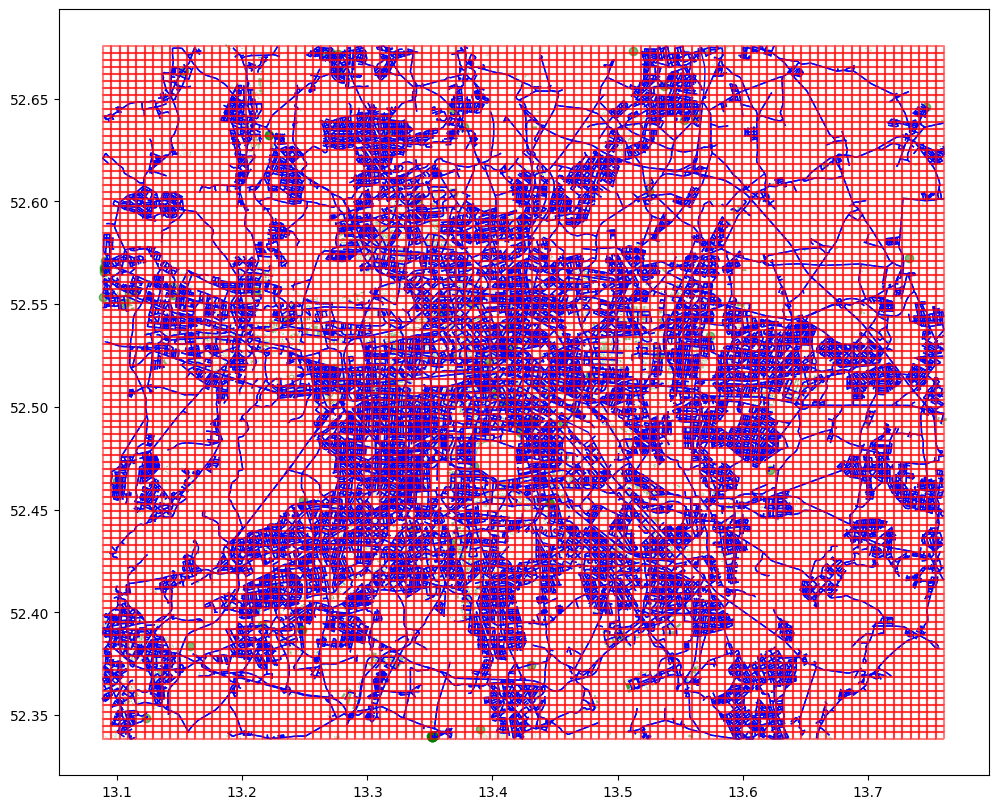

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))
roads_gdf.to_crs("EPSG:4326").plot(ax=ax, color='blue', linewidth=1)
buildings_gdf.plot(ax=ax, color='green', alpha=0.5)
grid_gdf.boundary.plot(ax=ax, color='red', alpha=0.5)
plt.show()


## Introduces random obstacles

In [9]:
obstacle_cost = 20
number_of_obstacles = 600
urban_area_likelihood = np.random.rand(num_x_cells * num_y_cells)

# Normalize the probabilities so they sum to 1.
urban_area_likelihood /= urban_area_likelihood.sum()

# Choose random cells based on urban area likelihood.
for _ in range(number_of_obstacles):
    # Choose a random index from the flattened grid.
    flat_index = np.random.choice(np.arange(num_x_cells * num_y_cells), p=urban_area_likelihood)
    
    # Convert the flat index to a 2D index.
    obstacle_y, obstacle_x = np.unravel_index(flat_index, (num_y_cells, num_x_cells))
    
    # Set the cost for the obstacle in the grid, ensuring it's within bounds
    if 0 <= obstacle_x < num_x_cells and 0 <= obstacle_y < num_y_cells:
        grid[obstacle_y, obstacle_x] = obstacle_cost
        print(grid)

[[ 5.  5.  5. ... inf inf inf]
 [ 5.  5.  5. ... inf inf inf]
 [ 5.  5.  5. ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]
[[ 5.  5.  5. ... inf inf inf]
 [ 5.  5.  5. ... inf inf inf]
 [ 5.  5.  5. ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]
[[ 5.  5.  5. ... inf inf inf]
 [ 5.  5.  5. ... inf inf inf]
 [ 5.  5.  5. ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]
[[ 5.  5.  5. ... inf inf inf]
 [ 5.  5.  5. ... inf inf inf]
 [ 5.  5.  5. ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]
[[ 5.  5.  5. ... inf inf inf]
 [ 5.  5.  5. ... inf inf inf]
 [ 5.  5.  5. ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]]
[[ 5.  5.  5. ... inf inf inf]
 [ 5.  5.

## Simulates dynamic traffic patterns & road closures

In [10]:
traffic_jam_cost = 6
closure_cost = np.inf

# Update traffic simulation to affect only roads
def simulate_traffic_jams(grid, road_cost, traffic_cost, num_jams=200):
    traffic_locations = np.argwhere(grid == road_cost)
    np.random.shuffle(traffic_locations)
    for location in traffic_locations[:num_jams]:
        grid[location[0], location[1]] = traffic_cost

# Apply road closures to road segments only
def apply_closures_on_roads(grid, road_cost, closure_cost):
    closure_locations = np.argwhere(grid == road_cost)
    np.random.shuffle(closure_locations)
    for location in closure_locations[:10]:  # Close 10 random road segments
        grid[location[0], location[1]] = closure_cost
        
simulate_traffic_jams(grid, road_cost, traffic_jam_cost)
apply_closures_on_roads(grid, road_cost, closure_cost)

Specifies the locations of hospitals

In [11]:
# Define the hospital coordinates
station_cost = 2
# Number of hospitals
num_stations = 64
station_locations = []

def find_road_cells(grid, road_cost):
    return np.argwhere(grid == road_cost)

def get_station_locations(road_cells, num_stations):
    np.random.shuffle(road_cells)
    return road_cells[:num_stations] if len(road_cells) >= num_stations else road_cells

road_cells = find_road_cells(grid, road_cost)
station_locations = get_station_locations(road_cells, num_stations)

# Print hospital locations
for i, (y, x) in enumerate(station_locations):
    print(f"Hospital {i}: ({x}, {y})")


Hospital 0: (84, 92)
Hospital 1: (19, 48)
Hospital 2: (92, 18)
Hospital 3: (97, 45)
Hospital 4: (89, 32)
Hospital 5: (70, 85)
Hospital 6: (74, 97)
Hospital 7: (76, 94)
Hospital 8: (86, 71)
Hospital 9: (90, 74)
Hospital 10: (29, 1)
Hospital 11: (90, 94)
Hospital 12: (9, 89)
Hospital 13: (37, 13)
Hospital 14: (57, 90)
Hospital 15: (72, 0)
Hospital 16: (3, 41)
Hospital 17: (24, 40)
Hospital 18: (22, 92)
Hospital 19: (87, 71)
Hospital 20: (55, 1)
Hospital 21: (35, 95)
Hospital 22: (66, 14)
Hospital 23: (72, 83)
Hospital 24: (41, 83)
Hospital 25: (8, 87)
Hospital 26: (92, 36)
Hospital 27: (85, 64)
Hospital 28: (77, 28)
Hospital 29: (66, 81)
Hospital 30: (57, 91)
Hospital 31: (87, 62)
Hospital 32: (20, 37)
Hospital 33: (27, 6)
Hospital 34: (84, 66)
Hospital 35: (3, 25)
Hospital 36: (70, 75)
Hospital 37: (3, 80)
Hospital 38: (8, 4)
Hospital 39: (55, 7)
Hospital 40: (54, 86)
Hospital 41: (71, 89)
Hospital 42: (80, 91)
Hospital 43: (42, 16)
Hospital 44: (16, 42)
Hospital 45: (54, 85)
Hospital 4

## Places emergency points on the grid 


In [12]:
# Function to place emergency destinations on the grid
def place_emergencies_on_grid(grid, num_emergencies, destination_cost):
    emergency_points = []
    for _ in range(num_emergencies):
        # Randomly select a point for the emergency
        emergency_x = np.random.randint(0, grid.shape[1])
        emergency_y = np.random.randint(0, grid.shape[0])
        # Check if the selected point is a road and not already occupied by a hospital
        if grid[emergency_y, emergency_x] == road_cost:
            grid[emergency_y, emergency_x] = destination_cost
            emergency_points.append((emergency_x, emergency_y))
    return emergency_points

# Function call to place emergencies
num_emergencies = 80  # for example
destination_cost = 4  #
emergency_locations = place_emergencies_on_grid(grid, num_emergencies, destination_cost)


## Visualizes the grid

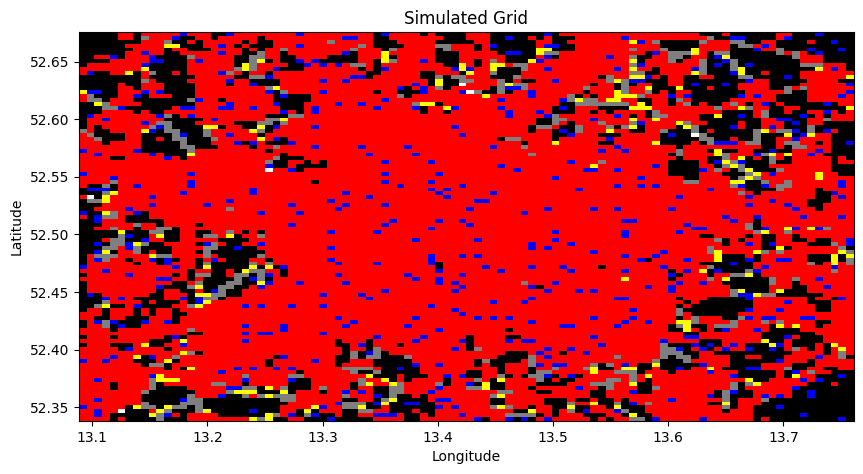

In [13]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define colors for each feature as RGB tuples
feature_colors = {
    'road_cost': (0.5, 0.5, 0.5),  # gray
    'building_cost': (1.0, 0.0, 0.0),  # red
    'obstacle_cost': (0.0, 0.0, 1.0),  # blue
    'traffic_jam_cost': (1.0, 1.0, 0.0),  # yellow
    'closure_cost': (0.0, 0.0, 0.0),  # black
    'station_cost': (0.0, 1.0, 0.0),  # green
    'default': (1.0, 1.0, 1.0)  # white
}

def map_cost_to_color(value, road_cost, building_cost, obstacle_cost, traffic_jam_cost, closure_cost, station_cost):
    if value == road_cost:
        return feature_colors['road_cost']
    elif value == building_cost:
        return feature_colors['building_cost']
    elif value == obstacle_cost:
        return feature_colors['obstacle_cost']
    elif value == traffic_jam_cost:
        return feature_colors['traffic_jam_cost']
    elif value == closure_cost:
        return feature_colors['closure_cost']
    elif value == station_cost:
        return feature_colors['station_cost']
    else:
        return feature_colors['default']

# Convert the grid to an (m, n, 3) array of RGB values
color_grid = np.empty((grid.shape[0], grid.shape[1], 3))
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        color_grid[i, j] = map_cost_to_color(grid[i, j], road_cost, building_cost, obstacle_cost, traffic_jam_cost, closure_cost, station_cost)

# Plot the grid with the custom colors
plt.figure(figsize=(10, 10))
plt.imshow(color_grid, origin='lower', extent=(west, east, south, north))
plt.title('Simulated Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Step 2: A* Algorithm implementation

In [14]:
import random
import heapq
import numpy as np
import time

def heuristic(a, b):
    # Manhattan distance on a square grid
    return abs(b[0] - a[0]) + abs(b[1] - a[1])

def a_star_search(grid, start, goal, cost_function):
    neighbors = [(0, 1), (1, 0), (-1, 0), (0, -1)]  # 4-connected grid
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []

    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            data = []
            path_cost = 0
            while current in came_from:
                data.append(current)
                path_cost += cost_function(current)  # Accumulate the path cost
                current = came_from[current]
            data.reverse()  # Optional: reverse the path to start -> goal
            return data, path_cost  # Return both the path and the path cost

        close_set.add(current)
        for i, j in neighbors:
            neighbor = (current[0] + i, current[1] + j)
            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor] == np.inf:  # Check if the neighbor is blocked
                    continue

                tentative_g_score = gscore[current] + cost_function(neighbor)
                if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, np.inf):
                    continue

                if tentative_g_score < gscore.get(neighbor, np.inf) or neighbor not in [i[1] for i in oheap]:
                    came_from[neighbor] = current
                    gscore[neighbor] = tentative_g_score
                    fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return False, np.inf  # If no path is found

def cost(point):
    y, x = point
    return grid[y, x] if grid[y, x] != np.inf else float('inf')

# Pick a random hospital as the start point and convert it to a tuple
start = tuple(random.choice(station_locations))

# Pick a random emergency location as the goal point and convert it to a tuple
goal = tuple(random.choice(emergency_locations))

# Start the timer
start_time = time.time()

# Run A* 
a_star_path, astar_path_cost = a_star_search(grid, start, goal, cost)

# End the timer
end_time = time.time()
a_star_time = end_time - start_time
# Output results
print("Path:", a_star_path)
print("Path cost:", astar_path_cost)
print("Time taken:", a_star_time)


Path: [(24, 3), (23, 3), (22, 3), (22, 4), (22, 5), (22, 6), (22, 7), (22, 8), (22, 9), (22, 10), (22, 11), (22, 12), (22, 13), (23, 13), (23, 14), (23, 15), (23, 16), (23, 17), (23, 18), (23, 19), (23, 20), (23, 21), (23, 22), (23, 23), (23, 24), (23, 25), (22, 25), (22, 26), (22, 27), (22, 28), (22, 29), (22, 30), (23, 30), (23, 31), (23, 32), (23, 33), (23, 34), (23, 35), (23, 36), (23, 37), (23, 38), (23, 39), (23, 40), (23, 41), (23, 42), (23, 43), (23, 44), (23, 45), (22, 45), (22, 46), (22, 47), (22, 48), (22, 49), (22, 50), (22, 51), (22, 52), (22, 53), (22, 54), (22, 55), (22, 56), (22, 57), (22, 58), (22, 59), (22, 60), (22, 61), (22, 62), (22, 63), (22, 64), (23, 64), (24, 64)]
Path cost: 342.0
Time taken: 0.032186269760131836


In [15]:
print(start)
print(goal)

(25, 3)
(24, 64)


# Step 3: Genetic Algortihm implementation

In [16]:
import numpy as np
import random

def heuristic(a, b):
    return abs(b[0] - a[0]) + abs(b[1] - a[1])

def fitness(path, goal, grid):
    if not path:
        return float('-inf')
    path_length_penalty = len(path)
    goal_distance = heuristic(path[-1], goal)
    return -(path_length_penalty + goal_distance * 2)  # Increase weight for goal proximity


def is_valid_move(point, grid):
    y, x = point
    return 0 <= x < grid.shape[1] and 0 <= y < grid.shape[0] and grid[y, x] != np.inf

def initialize_population(pop_size, grid, start, goal, max_path_length):
    population = []
    # Entire population now biased towards the goal
    for _ in range(pop_size):
        path = [start]
        while len(path) < max_path_length:
            current = path[-1]
            direction_to_goal = (np.sign(goal[0] - current[0]), np.sign(goal[1] - current[1]))
            next_step = (current[0] + direction_to_goal[0], current[1] + direction_to_goal[1])
            if is_valid_move(next_step, grid):
                path.append(next_step)
            else:
                break
        population.append(path)

    return population

def select_parents(population, fitnesses, num_parents):
   
    parents = []
    tournament_size = 3
    while len(parents) < num_parents:
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        tournament.sort(key=lambda x: x[1], reverse=True)
        parents.append(tournament[0][0])  # Select the best from the tournament
    return parents

def crossover(parent1, parent2):

    if len(parent1) > 1 and len(parent2) > 1:
        min_len = min(len(parent1), len(parent2))
        # Safe guard to prevent crossover_point from being invalid
        crossover_point = random.randint(1, min_len - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
    else:
        
        child1, child2 = parent2, parent1

    return child1, child2

def mutate(path, mutation_rate, grid, goal, max_path_length):

    if not path or path[0] != start:
        path = [start]  # Reinitialize path with start point

    if len(path) == 1:
        # Add a new point if possible
        directions = [(0, 1), (1, 0), (-1, 0), (0, -1)]
        next_steps = [(path[0][0] + d[0], path[0][1] + d[1]) for d in directions]
        valid_steps = [step for step in next_steps if is_valid_move(step, grid)]
        if valid_steps:
            path.append(random.choice(valid_steps))

    if random.random() < mutation_rate:
        mutation_type = random.choice(['extend', 'trim', 'swap'])
        
        if mutation_type == 'extend' and len(path) < max_path_length:
            extension_length = random.randint(1, 5)
            for _ in range(extension_length):
                if len(path) >= max_path_length:
                    break
                directions = [(0, 1), (1, 0), (-1, 0), (0, -1)]
                last_move = path[-1]
                next_steps = [(last_move[0] + d[0], last_move[1] + d[1]) for d in directions]
                valid_steps = [step for step in next_steps if is_valid_move(step, grid)]
                if valid_steps:
                    path.append(random.choice(valid_steps))
        
        elif mutation_type == 'trim' and len(path) > 2:
            trim_start = random.randint(0, len(path) - 2)
            trim_end = random.randint(trim_start + 1, len(path))
            path = [start] + path[:trim_start] + path[trim_end:]
        
        elif mutation_type == 'swap' and len(path) > 2:  # Adjusted to only swap if path length > 2
            idx1, idx2 = random.sample(range(1, len(path)), 2)  # Exclude the start point from the swap
            path[idx1], path[idx2] = path[idx2], path[idx1]

    # Attempt to extend the path towards the goal if it's shorter than max_path_length
    if len(path) < max_path_length:
        while len(path) < max_path_length:
            current = path[-1]
            direction_to_goal = (np.sign(goal[0] - current[0]), np.sign(goal[1] - current[1]))
            next_step = (current[0] + direction_to_goal[0], current[1] + direction_to_goal[1])
            if is_valid_move(next_step, grid):
                path.append(next_step)
            else:
                break
    
    return path

# Genetic algorithm with elitism and dynamic mutation rate
def genetic_algorithm(grid, start, goal, pop_size=100, max_generations=100, max_path_length=50):
    population= initialize_population(pop_size, grid, start, goal, max_path_length)
    best_path = None
    best_fitness = float('-inf')
    stagnant_generations = 0  # Track generations without improvement

    for generation in range(max_generations):
        fitnesses = [fitness(path, goal, grid) for path in population]
        new_best_fitness = max(fitnesses)
        if new_best_fitness > best_fitness:
            best_fitness = new_best_fitness
            best_path = population[fitnesses.index(best_fitness)]
            stagnant_generations = 0  # Reset if there's improvement
        else:
            stagnant_generations += 1  # Increment if no improvement

        parents = select_parents(population, fitnesses, pop_size // 2)
        next_generation = [best_path]  # Start next gen with the best path (elitism)

        # Dynamic mutation rate based on stagnation
        mutation_rate = 0.1 if stagnant_generations < 10 else 0.2

        while len(next_generation) < pop_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate, grid, goal,max_path_length)
            child2 = mutate(child2, mutation_rate, grid, goal,max_path_length)
            next_generation.extend([child1, child2])

        population = next_generation

        if generation % 10 == 0:
            print(f"Generation {generation}: Best Fitness = {best_fitness}")

    return best_path, best_fitness

start_time = time.time()
best_path, best_fitness = genetic_algorithm(grid, start, goal)
end_time = time.time()
ga_time = start_time - end_time
print("Best Path:", best_path)
print("Best Fitness:", best_fitness)
print("Time taken:", ga_time)


Generation 0: Best Fitness = -125
Generation 10: Best Fitness = -50
Generation 20: Best Fitness = -50
Generation 30: Best Fitness = -50
Generation 40: Best Fitness = -50
Generation 50: Best Fitness = -50
Generation 60: Best Fitness = -50
Generation 70: Best Fitness = -50
Generation 80: Best Fitness = -50
Generation 90: Best Fitness = -50
Best Path: [(25, 3), (25, 3), (24, 41), (24, 42), (24, 43), (24, 44), (24, 45), (24, 46), (24, 47), (24, 48), (24, 49), (24, 50), (24, 51), (24, 52), (24, 53), (24, 54), (24, 55), (24, 56), (24, 57), (24, 58), (24, 59), (24, 60), (24, 61), (24, 62), (24, 63), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64), (24, 64)]
Best Fitness: -50
Time taken: -0.06299853324890137


# Step 4: Comparing the result of both the algorithms

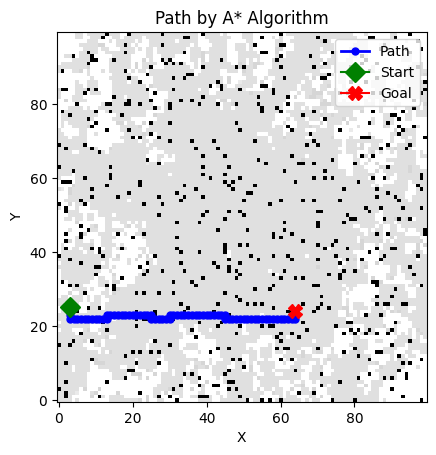

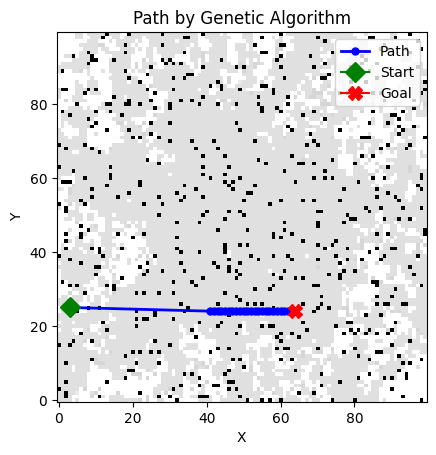

In [17]:
import matplotlib.pyplot as plt

def plot_path(grid, path, start, goal, title):
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap='Greys', origin='lower')

    # Convert path to X and Y coordinates for plotting
    y, x = zip(*path)
    ax.plot(x, y, marker='o', color='b', markersize=5, linestyle='-', linewidth=2, label='Path')

    # Mark the start and goal
    ax.plot(start[1], start[0], marker='D', color='green', markersize=10, label='Start')
    ax.plot(goal[1], goal[0], marker='X', color='red', markersize=10, label='Goal')

    ax.legend()
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


plot_path(grid, a_star_path, start, goal, 'Path by A* Algorithm')
plot_path(grid, best_path, start, goal, 'Path by Genetic Algorithm')


In [18]:
import pandas as pd

# Assuming you have 'path_cost_a_star', 'path_cost_ga', 'time_a_star', 'time_ga'
data = {
    'Metric': ['Path Length', 'Path Cost', 'Computation Time (s)'],
    'A* Algorithm': [len(a_star_path),a_star_path, a_star_time],
    'Genetic Algorithm': [len(best_path), best_path, ga_time]
}

df = pd.DataFrame(data, columns=['Metric', 'A* Algorithm', 'Genetic Algorithm'])
df


,Metric,A* Algorithm,Genetic Algorithm
0,Path Length,70,50
1,Path Cost,"[(24, 3), (23, 3), (22, 3), (22, 4), (22, 5), ...","[(25, 3), (25, 3), (24, 41), (24, 42), (24, 43..."
2,Computation Time (s),0.032186,-0.062999
